In [ ]:
# prompt: hubungkan google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pyspark

### Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pickle
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml import Pipeline

### Loading dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/BIG DATA LANJUT/dataset.csv', index_col=0) #index_col 0 to drop the extra index column

### Viewing the data

In [ ]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Checking summary of the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

In [ ]:
df.shape #(rows, columns)

(114000, 20)

### Looking for null values

In [ ]:
df[df.isnull().any(axis=1)]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


* Since there is only one row containing null values, I'll drop this row

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df['track_genre'].nunique() # Checking how many genres are there

114

In [ ]:
df["explicit"]=df["explicit"].astype(int) #True=1 and False=0

<ipython-input-11-4e90e0e4d8e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explicit"]=df["explicit"].astype(int) #True=1 and False=0


In [ ]:
df[df.duplicated()] # checking duplicate rows

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1925,0CDucx9lKxuCZplLXUz0iX,Buena Onda Reggae Club,Disco 2,Song for Rollins,16,219346,0,0.841,0.577,0,-7.544,1,0.0438,0.238000,0.860000,0.0571,0.843,90.522,4,afrobeat
2155,2aibwv5hGXSgw7Yru8IYTO,Red Hot Chili Peppers,Stadium Arcadium,Snow (Hey Oh),80,334666,0,0.427,0.900,11,-3.674,1,0.0499,0.116000,0.000017,0.1190,0.599,104.655,4,alt-rock
3738,7mULVp0DJrI2Nd6GesLvxn,Joy Division,Timeless Rock Hits,Love Will Tear Us Apart,0,204621,0,0.524,0.902,2,-8.662,1,0.0368,0.000989,0.695000,0.1370,0.907,146.833,4,alternative
4648,6d3RIvHfVkoOtW1WHXmbX3,Little Symphony,Serenity,Margot,27,45714,0,0.269,0.142,0,-23.695,1,0.0509,0.866000,0.904000,0.1140,0.321,67.872,3,ambient
5769,481beimUiUnMUzSbOAFcUT,SUPER BEAVER,突破口 / 自慢になりたい,突破口,54,255080,0,0.472,0.994,8,-1.786,1,0.1140,0.025900,0.000000,0.0535,0.262,103.512,4,anime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111246,0sSjIvTvd6fUSZZ5rnTPDW,Everything But The Girl,Eden (Deluxe Edition),Another Bridge - 2012 Remaster,26,132826,0,0.480,0.853,0,-6.276,1,0.0734,0.030600,0.000001,0.3200,0.775,85.181,4,trip-hop
111362,2zg3iJW4fK7KZgHOvJU67z,Faithless,Faithless 2.0,Tarantula,21,398152,0,0.622,0.816,6,-11.095,0,0.0483,0.009590,0.578000,0.0991,0.427,136.007,4,trip-hop
111980,46FPub2Fewe7XrgM0smTYI,Morcheeba,Parts of the Process,Undress Me Now,17,203773,0,0.576,0.352,7,-10.773,0,0.0268,0.700000,0.270000,0.1600,0.360,95.484,4,trip-hop
112968,6qVA1MqDrDKfk9144bhoKp,Acil Servis,Küçük Adam,Bebek,38,319933,0,0.486,0.485,5,-12.391,0,0.0331,0.004460,0.000017,0.3690,0.353,120.095,4,turkish


### Descriptive Statistics

In [ ]:
df.describe().style.background_gradient(cmap="Accent") # Dark boxes denote very high values

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,33.238827,228031.153387,0.085501,0.566801,0.641383,5.309126,-8.258950,0.637558,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695,3.904034
std,22.304959,107296.057716,0.279627,0.173543,0.251530,3.559999,5.029357,0.480708,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290,0.432623
min,0.000000,8586.000000,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,174066.000000,0.000000,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500,4.000000
50%,35.000000,212906.000000,0.000000,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,261506.000000,0.000000,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5237295.000000,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


### Correlation Analysis

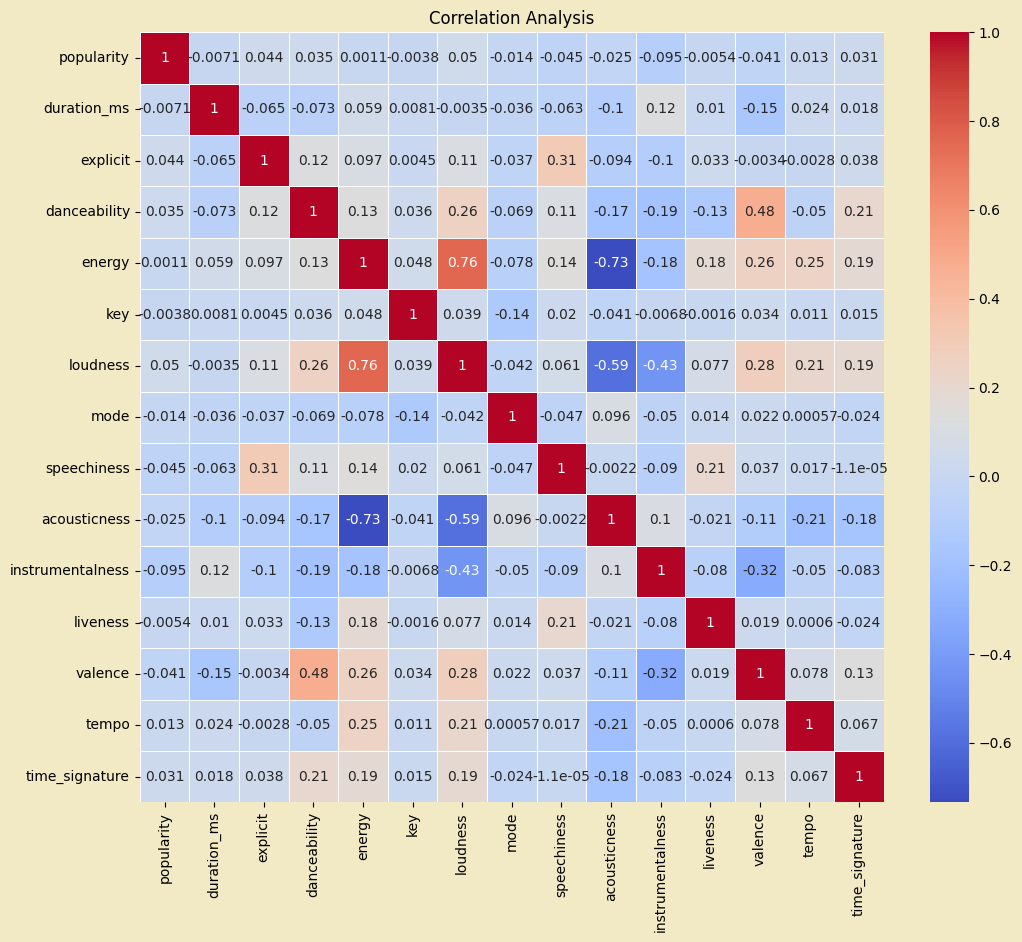

In [ ]:
# Including numerical colmumns
corr_mat = df.select_dtypes(include=["int", "float"]).corr()

# Adjusting figure visuals
plt.figure(figsize=(12, 10), facecolor='#F2EAC5', edgecolor='black')
ax = plt.axes()
ax.set_facecolor('#F2EAC5')
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Analysis')
plt.show()

### Selecting Numerical columns for further analysis

In [ ]:
num_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
num_cols.shape

(113999, 15)

In [ ]:
num_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        113999 non-null  int64  
 1   duration_ms       113999 non-null  int64  
 2   explicit          113999 non-null  int64  
 3   danceability      113999 non-null  float64
 4   energy            113999 non-null  float64
 5   key               113999 non-null  int64  
 6   loudness          113999 non-null  float64
 7   mode              113999 non-null  int64  
 8   speechiness       113999 non-null  float64
 9   acousticness      113999 non-null  float64
 10  instrumentalness  113999 non-null  float64
 11  liveness          113999 non-null  float64
 12  valence           113999 non-null  float64
 13  tempo             113999 non-null  float64
 14  time_signature    113999 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 13.9 MB


### Checking distribution of numerical columns

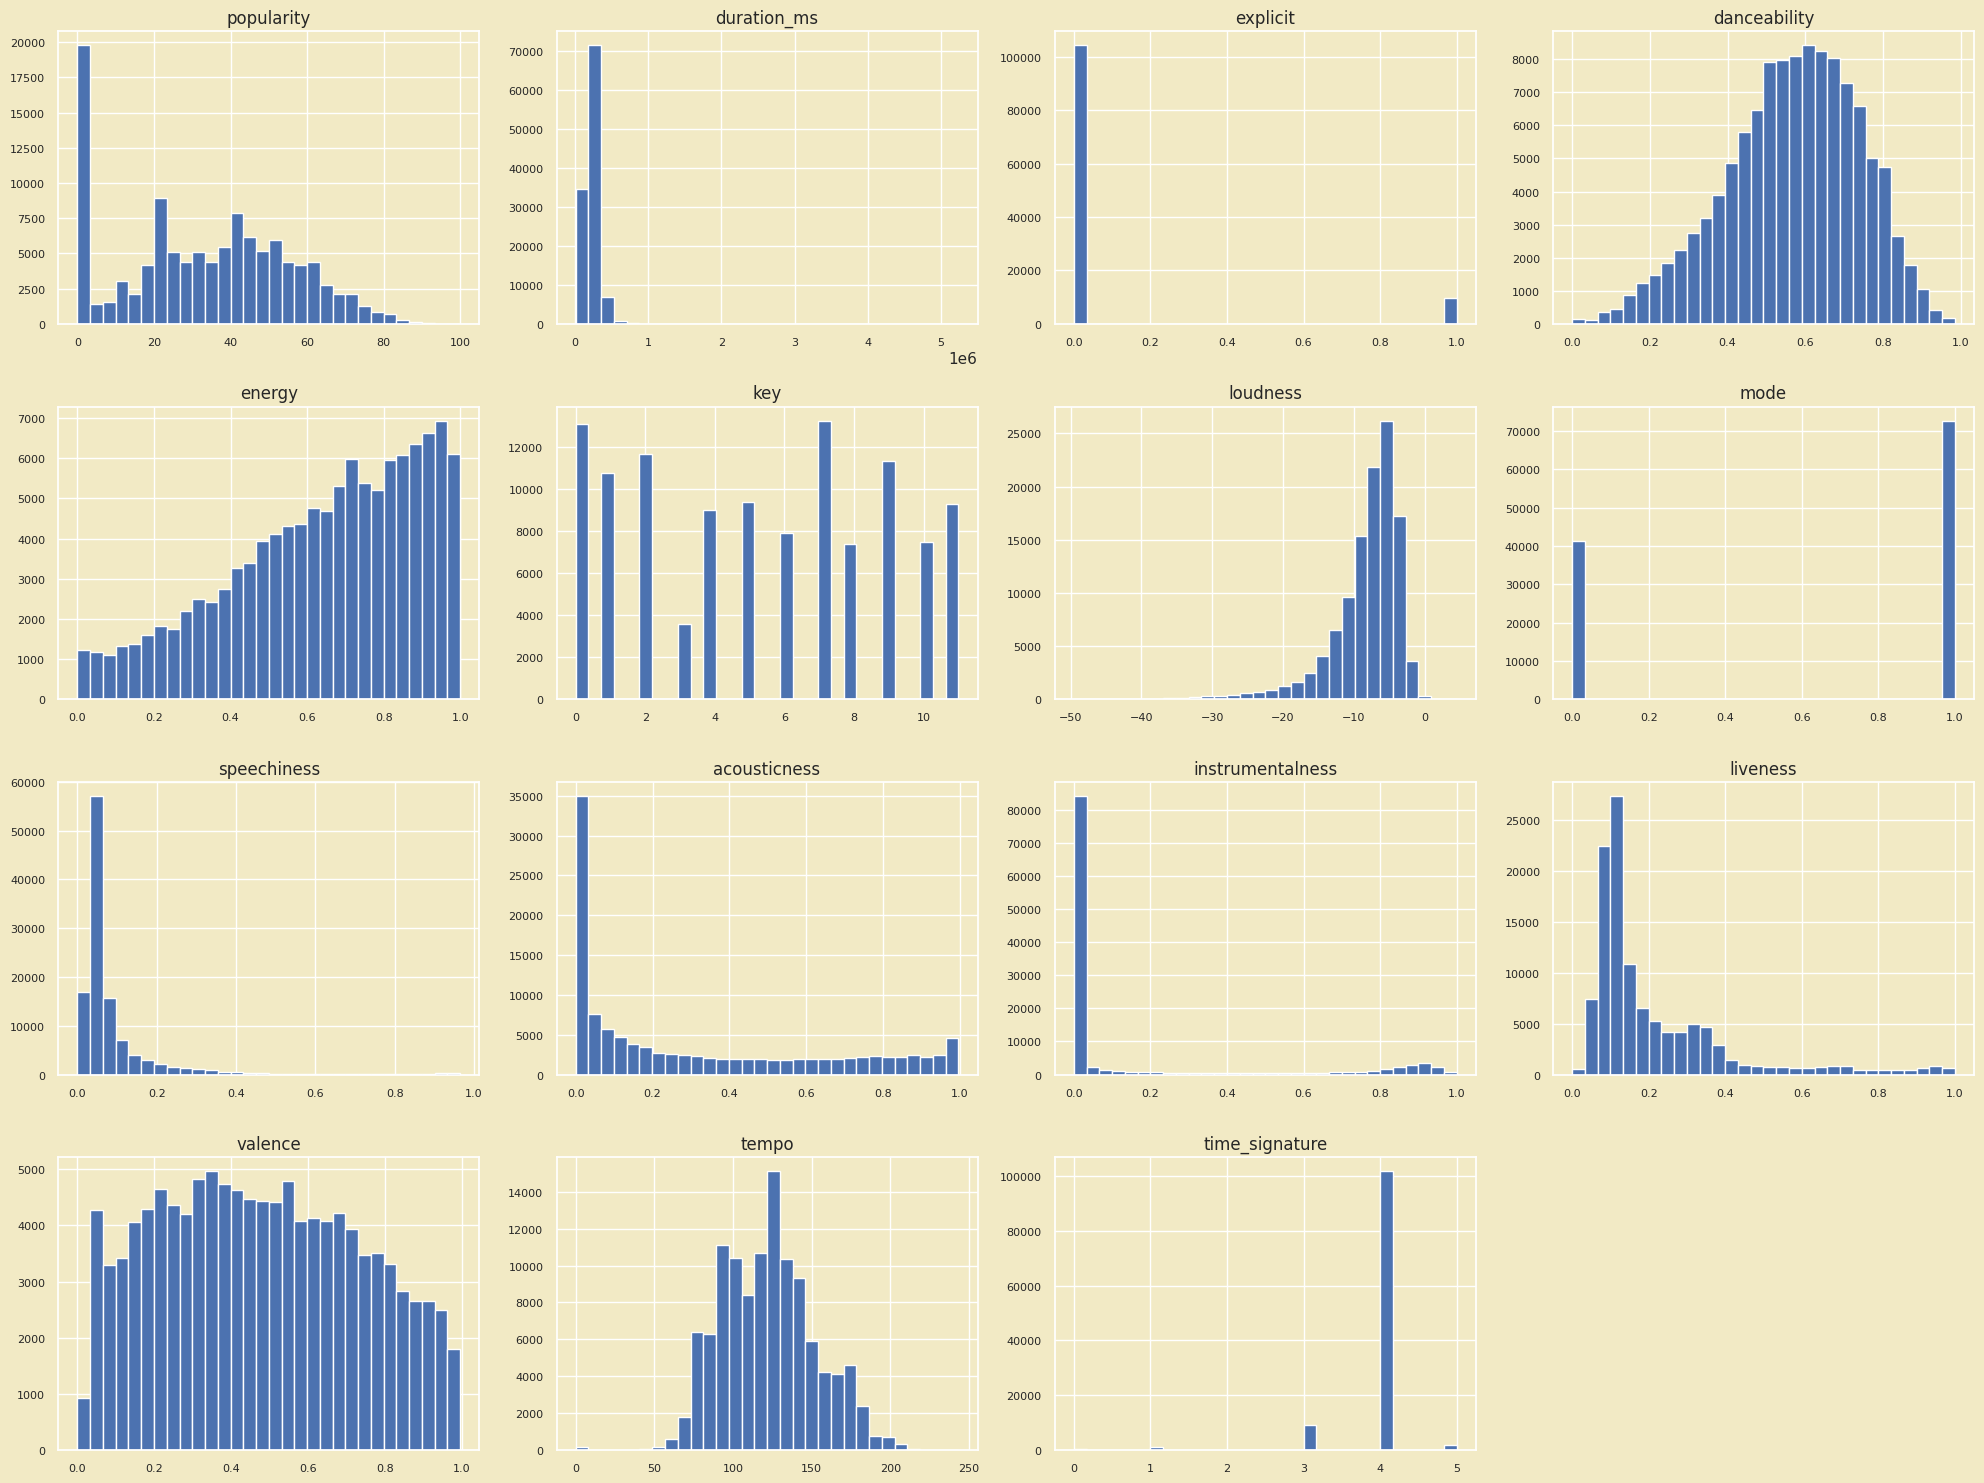

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
num_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Select and scale the relevant features
features = df[['danceability','energy', 'loudness', 'valence', 'tempo']] # features selected by refering correlation matrix
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
df['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [ ]:
# Genre to category mapping for playlist creation
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music',
    'house': 'Electronic Dance Music',
    'electro': 'Electronic Dance Music',
    'trance': 'Electronic Dance Music',
    'techno': 'Electronic Dance Music',
    'dubstep': 'Electronic Dance Music',
    'drum-and-bass': 'Electronic Dance Music',
    'deep-house': 'Electronic Dance Music',
    'detroit-techno': 'Electronic Dance Music',
    'minimal-techno': 'Electronic Dance Music',
    'progressive-house': 'Electronic Dance Music',
    'breakbeat': 'Electronic Dance Music',

    # Rock
    'alt-rock': 'Rock',
    'rock': 'Rock',
    'indie': 'Rock',
    'indie-pop': 'Rock',
    'punk': 'Rock',
    'punk-rock': 'Rock',
    'hard-rock': 'Rock',
    'metal': 'Rock',
    'heavy-metal': 'Rock',
    'black-metal': 'Rock',
    'death-metal': 'Rock',
    'grunge': 'Rock',

    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B',
    'r-n-b': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Pop
    'pop': 'Pop',
    'electro-pop': 'Pop',
    'synth-pop': 'Pop',
    'k-pop': 'Pop',
    'pop-film': 'Pop',
    'power-pop': 'Pop',

    # Latin & Reggae/Dancehall
    'latin': 'Latin & Reggae/Dancehall',
    'reggaeton': 'Latin & Reggae/Dancehall',
    'salsa': 'Latin & Reggae/Dancehall',
    'samba': 'Latin & Reggae/Dancehall',
    'reggae': 'Latin & Reggae/Dancehall',
    'dancehall': 'Latin & Reggae/Dancehall',

    # Funk and Disco
    'funk': 'Funk and Disco',
    'disco': 'Funk and Disco',
    'groove': 'Funk and Disco',
}

# Map each track to a category
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113999 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        113999 non-null  int64  
 5   duration_ms       113999 non-null  int64  
 6   explicit          113999 non-null  int64  
 7   danceability      113999 non-null  float64
 8   energy            113999 non-null  float64
 9   key               113999 non-null  int64  
 10  loudness          113999 non-null  float64
 11  mode              113999 non-null  int64  
 12  speechiness       113999 non-null  float64
 13  acousticness      113999 non-null  float64
 14  instrumentalness  113999 non-null  float64
 15  liveness          113999 non-null  float64
 16  valence           113999 

In [ ]:
df.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,music_category
55379,52B3XCIgDUwQLj2ZdmykRF,Pritam;Mohan Kannan;Amitabh Bhattacharya,Laal Singh Chaddha,Kahani,52,208539,0,0.406,0.336,1,...,1,0.0345,0.8150,0.000005,0.0888,0.327,149.354,3,indian,Other
39817,7kDSAQQkmuqECgUBWcozrm,FFRAGEZEICHEN,FR EP 2,Passed Out,38,125000,1,0.900,0.573,1,...,1,0.3530,0.1180,0.000000,0.0869,0.236,100.015,4,german,Other
113781,7GyF1KwnX5YBxPw2gjbfOd,Shane & Shane,Vintage,Lord I Lift Your Name on High,42,196022,0,0.549,0.466,2,...,1,0.0379,0.2000,0.000001,0.1210,0.258,149.870,4,world-music,Other
91185,2AjLI6h9DZrFw0XVtTYwdT,blink-182,Rock Workout 2023,All The Small Things,1,171066,0,0.442,0.900,0,...,1,0.0529,0.0109,0.000000,0.3950,0.609,148.620,4,rock,Rock
5956,47ltbGJTejvcljxYfzAlUZ,JUNNA,コノユビトマレ,コノユビトマレ,49,299200,0,0.472,0.924,7,...,0,0.2180,0.0225,0.000000,0.1110,0.441,144.812,4,anime,Other


In [ ]:
#music categories for different playlists
df['music_category'].unique()

array(['Other', 'Rock', 'Electronic Dance Music',
       'Latin & Reggae/Dancehall', 'Funk and Disco', 'Hip-Hop and R&B',
       'Pop'], dtype=object)

In [ ]:
#Clustering songs in different playlists
from sklearn.cluster import KMeans # Ensure you're using sklearn's KMeans

kmeans = KMeans(n_clusters=7, random_state=48) # This will now use the correct KMeans
df['cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
#PCA for visualisation
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("MusicRecommendation").getOrCreate()

# Convert the Pandas DataFrame to a PySpark DataFrame
spark_df = spark.createDataFrame(df)

# Now you can use randomSplit on the spark_df
train_data, test_data = spark_df.randomSplit([0.6, 0.4], seed=0)


# Prepare features using VectorAssembler
assembler = VectorAssembler(inputCols=num_cols.columns.tolist(), outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Index the target column (for classification models)
indexer = StringIndexer(inputCol="music_category", outputCol="indexed_music_category")
train_data = indexer.fit(train_data).transform(train_data)
test_data = indexer.fit(test_data).transform(test_data)

In [ ]:
# Pilih kolom yang ingin disimpan
final_data = train_data.select("features", "indexed_music_category")

# Konversi ke Pandas DataFrame
final_pandas_data = final_data.toPandas()

# Ekstrak kolom `features` menjadi beberapa kolom numerik
features_df = pd.DataFrame(
    final_pandas_data['features'].apply(lambda x: x.toArray()).tolist(),
    columns=[f'feature_{i}' for i in range(len(final_pandas_data['features'][0]))]
)

# Gabungkan dengan kolom target
final_pandas_data = pd.concat([features_df, final_pandas_data['indexed_music_category']], axis=1)

# Simpan ke Google Drive
output_path = '/content/drive/MyDrive/preprocessed_train_data.csv'
final_pandas_data.to_csv(output_path, index=False)

print(f"Dataset yang sudah diproses disimpan di: {output_path}")


Dataset yang sudah diproses disimpan di: /content/drive/MyDrive/preprocessed_train_data.csv


In [ ]:
# Classification models
models_classification = {
    'Gradient Boosting Tree': GBTClassifier(labelCol='indexed_music_category', featuresCol='features'),
    'Random Forest': RandomForestClassifier(labelCol='indexed_music_category', featuresCol='features'),
    'Logistic Regression': LogisticRegression(labelCol='indexed_music_category', featuresCol='features')
}

# Clustering models
from pyspark.ml.clustering import KMeans # This line ensures you are using the PySpark KMeans
models_clustering = {
    'K-Means': KMeans(featuresCol='features', predictionCol='prediction', k=3, seed=0), # Changed 'k' to 'n_clusters'
    'Gaussian Mixture': GaussianMixture(k=3, seed=0, featuresCol='features', predictionCol='prediction')
}

In [ ]:
if "features" in train_data.columns:
    train_data = train_data.drop("features")

if "features" in test_data.columns:
    test_data = test_data.drop("features")




In [ ]:
from pyspark.ml.feature import VectorAssembler

# Pastikan semua kolom numerik dipilih dengan benar
num_cols = ['danceability', 'energy', 'loudness', 'valence', 'tempo']

assembler = VectorAssembler(inputCols=num_cols, outputCol="features")

# Transform train_data dan test_data
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)


In [ ]:
print(train_data.columns)
print(train_data.schema['features'].dataType)
# Periksa distribusi nilai pada kolom label
train_data.select("indexed_music_category").distinct().show()



['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'music_category', 'cluster', 'indexed_music_category', 'features']
VectorUDT()
+----------------------+
|indexed_music_category|
+----------------------+
|                   0.0|
|                   1.0|
|                   3.0|
|                   2.0|
|                   6.0|
|                   5.0|
|                   4.0|
+----------------------+



In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="indexed_music_category", featuresCol="features", numTrees=10)
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)


In [ ]:
# Mapping nilai label menjadi 0 atau 1
from pyspark.sql.functions import when

train_data = train_data.withColumn(
    "indexed_music_category",
    when(train_data["indexed_music_category"] == 0, 0).otherwise(1)
)

test_data = test_data.withColumn(
    "indexed_music_category",
    when(test_data["indexed_music_category"] == 0, 0).otherwise(1)
)


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='indexed_music_category',
    predictionCol='prediction',
    metricName='accuracy'
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='indexed_music_category',
    predictionCol='prediction',
    metricName='f1'
)
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol='indexed_music_category',
    predictionCol='prediction',
    metricName='weightedPrecision'
)
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol='indexed_music_category',
    predictionCol='prediction',
    metricName='weightedRecall'
)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='indexed_music_category',
    rawPredictionCol='prediction',
    metricName='areaUnderROC'
)

# Training and evaluating classification models
for model_name, model in models_classification.items():
    print(f"\n--- {model_name} ---")
    # Train the model
    model_trained = model.fit(train_data)

    # Make predictions
    predictions = model_trained.transform(test_data)

    # Calculate metrics
    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC (ROC Curve): {auc:.4f}")



--- Gradient Boosting Tree ---
Accuracy: 0.6864
F1 Score: 0.6562
Precision: 0.6686
Recall: 0.6864
AUC (ROC Curve): 0.6017

--- Random Forest ---
Accuracy: 0.6682
F1 Score: 0.5933
Precision: 0.6521
Recall: 0.6682
AUC (ROC Curve): 0.5469

--- Logistic Regression ---
Accuracy: 0.6537
F1 Score: 0.6192
Precision: 0.6244
Recall: 0.6537
AUC (ROC Curve): 0.5645


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Clustering evaluator
evaluator_clustering = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')

# Training and evaluating clustering models
for model_name, model in models_clustering.items():
    print(f"\n--- {model_name} ---")
    # Train the model
    model_trained = model.fit(train_data)

    # Make predictions
    predictions = model_trained.transform(test_data)

    # Calculate Silhouette Score
    silhouette_score = evaluator_clustering.evaluate(predictions)
    print(f"Silhouette Score: {silhouette_score:.4f}")



--- K-Means ---
Silhouette Score: 0.7110

--- Gaussian Mixture ---
Silhouette Score: 0.0415


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Param grid for Gradient Boosting Tree
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(models_classification['Gradient Boosting Tree'].maxDepth, [5, 10]) \
    .addGrid(models_classification['Gradient Boosting Tree'].maxIter, [10, 20]) \
    .build()

# CrossValidator
crossval_gbt = CrossValidator(
    estimator=models_classification['Gradient Boosting Tree'],
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator_accuracy,
    numFolds=3
)

# Perform cross-validation
cv_model_gbt = crossval_gbt.fit(train_data)
best_model_gbt = cv_model_gbt.bestModel

# Evaluate best model on test data
best_predictions_gbt = best_model_gbt.transform(test_data)
best_accuracy_gbt = evaluator_accuracy.evaluate(best_predictions_gbt)
print(f"Best GBT Accuracy after tuning: {best_accuracy_gbt:.4f}")


Best GBT Accuracy after tuning: 0.6886


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# ----------------------------------------------
# Param grid for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(models_classification['Random Forest'].maxDepth, [5, 10]) \
    .addGrid(models_classification['Random Forest'].numTrees, [50, 100]) \
    .build()

# CrossValidator for Random Forest
crossval_rf = CrossValidator(
    estimator=models_classification['Random Forest'],
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_accuracy,
    numFolds=3
)

# Perform cross-validation for Random Forest
cv_model_rf = crossval_rf.fit(train_data)
best_model_rf = cv_model_rf.bestModel

# Evaluate best model for Random Forest on test data
best_predictions_rf = best_model_rf.transform(test_data)
best_accuracy_rf = evaluator_accuracy.evaluate(best_predictions_rf)
print(f"Best RF Accuracy after tuning: {best_accuracy_rf:.4f}")


# ----------------------------------------------
# Param grid for Logistic Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(models_classification['Logistic Regression'].regParam, [0.01, 0.1]) \
    .addGrid(models_classification['Logistic Regression'].elasticNetParam, [0.0, 0.5]) \
    .build()

# CrossValidator for Logistic Regression
crossval_lr = CrossValidator(
    estimator=models_classification['Logistic Regression'],
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_accuracy,
    numFolds=3
)

# Perform cross-validation for Logistic Regression
cv_model_lr = crossval_lr.fit(train_data)
best_model_lr = cv_model_lr.bestModel

# Evaluate best model for Logistic Regression on test data
best_predictions_lr = best_model_lr.transform(test_data)
best_accuracy_lr = evaluator_accuracy.evaluate(best_predictions_lr)
print(f"Best Logistic Regression Accuracy after tuning: {best_accuracy_lr:.4f}")


Best RF Accuracy after tuning: 0.6953
Best Logistic Regression Accuracy after tuning: 0.6533


In [ ]:
paramGrid_kmeans = ParamGridBuilder() \
    .addGrid(models_clustering['K-Means'].k, [3, 5, 7]) \
    .build()

# CrossValidator for K-Means (manual iteration since CrossValidator isn't directly compatible with clustering)
best_silhouette_score = -1
best_kmeans_model = None

for params in paramGrid_kmeans:
    model = models_clustering['K-Means'].copy(params)
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)
    silhouette_score = evaluator_clustering.evaluate(predictions)
    if silhouette_score > best_silhouette_score:
        best_silhouette_score = silhouette_score
        best_kmeans_model = trained_model

print(f"Best Silhouette Score after tuning: {best_silhouette_score:.4f}")


Best Silhouette Score after tuning: 0.7110


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# ---- 1. Evaluator Setup ----
# Evaluator untuk klasifikasi biner (AUC, precision, recall)
binary_evaluator = BinaryClassificationEvaluator(labelCol="indexed_music_category", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluator untuk multiklas (akurasi, F1-score, precision, recall)
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="indexed_music_category", predictionCol="prediction")

# ---- 2. Latih dan Evaluasi Model ----
# Daftar model
models = {
    "Gradient Boosted Tree": GBTClassifier(labelCol="indexed_music_category", featuresCol="features", maxIter=10),
    "Random Forest": RandomForestClassifier(labelCol="indexed_music_category", featuresCol="features", numTrees=10)
}

# Simpan hasil evaluasi
evaluation_results = []

for model_name, model in models.items():
    print(f"\n--- Evaluating {model_name} ---")

    # Latih model
    trained_model = model.fit(train_data)

    # Prediksi
    predictions = trained_model.transform(test_data)

    # Evaluasi biner (AUC-ROC)
    auc = binary_evaluator.evaluate(predictions)

    # Evaluasi multiklas (akurasi, F1, dll.)
    accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
    f1 = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
    precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
    recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

    # Simpan hasil
    evaluation_results.append({
        "Model": model_name,
        "AUC": auc,
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Precision": precision,
        "Recall": recall
    })

    print(f"AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# ---- 3. Tampilkan Hasil Evaluasi ----
print("\n--- Summary of Model Evaluation ---")
for result in evaluation_results:
    print(f"{result['Model']} -> AUC: {result['AUC']:.4f}, Accuracy: {result['Accuracy']:.4f}, F1: {result['F1-Score']:.4f}, Precision: {result['Precision']:.4f}, Recall: {result['Recall']:.4f}")

# ---- 4. Pilih Model Terbaik ----
best_model = max(evaluation_results, key=lambda x: x["AUC"])
print(f"\nBest Model: {best_model['Model']} with AUC: {best_model['AUC']:.4f}")



--- Evaluating Gradient Boosted Tree ---
AUC: 0.7128, Accuracy: 0.6800, F1-Score: 0.6440, Precision: 0.6602, Recall: 0.6800

--- Evaluating Random Forest ---
AUC: 0.6916, Accuracy: 0.6661, F1-Score: 0.5991, Precision: 0.6430, Recall: 0.6661

--- Summary of Model Evaluation ---
Gradient Boosted Tree -> AUC: 0.7128, Accuracy: 0.6800, F1: 0.6440, Precision: 0.6602, Recall: 0.6800
Random Forest -> AUC: 0.6916, Accuracy: 0.6661, F1: 0.5991, Precision: 0.6430, Recall: 0.6661

Best Model: Gradient Boosted Tree with AUC: 0.7128


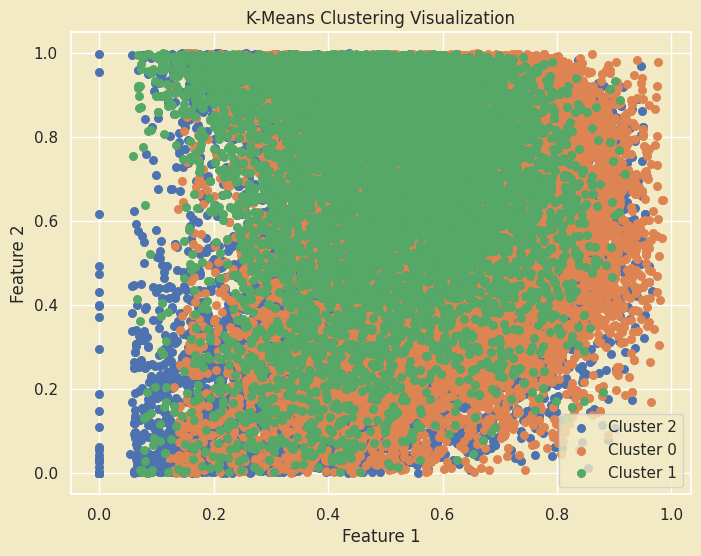

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Konfigurasi model K-Means
kmeans = KMeans(k=3, seed=1, featuresCol="features")  # 'k' adalah jumlah kluster
model_kmeans = kmeans.fit(train_data)  # Pastikan train_data terdefinisi

# Prediksi cluster untuk data test
predictions_kmeans = model_kmeans.transform(test_data)

pandas_kmeans = predictions_kmeans.select("features", "prediction").toPandas()
pandas_kmeans["x"] = pandas_kmeans["features"].apply(lambda x: x[0])  # Ambil fitur pertama
pandas_kmeans["y"] = pandas_kmeans["features"].apply(lambda x: x[1])  # Ambil fitur kedua

# Scatter plot untuk clustering
plt.figure(figsize=(8, 6))
for cluster in pandas_kmeans["prediction"].unique():
    cluster_data = pandas_kmeans[pandas_kmeans["prediction"] == cluster]
    plt.scatter(cluster_data["x"], cluster_data["y"], label=f"Cluster {cluster}", s=30)

plt.title("K-Means Clustering Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


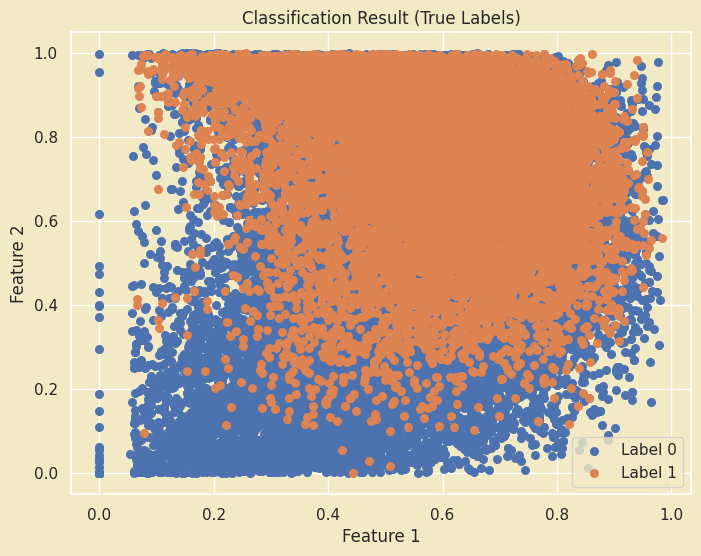

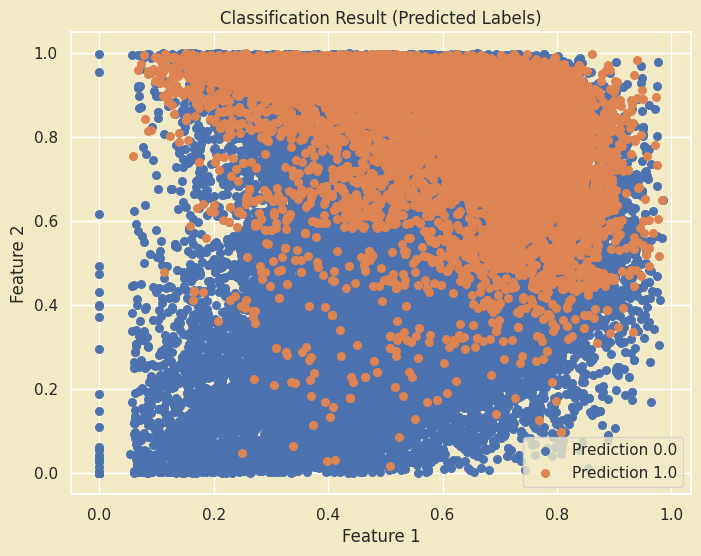

In [ ]:
# Convert predictions to Pandas DataFrame
pandas_classification = best_predictions_gbt.select("features", "indexed_music_category", "prediction").toPandas()
pandas_classification["x"] = pandas_classification["features"].apply(lambda x: x[0])  # Ambil fitur pertama
pandas_classification["y"] = pandas_classification["features"].apply(lambda x: x[1])  # Ambil fitur kedua

# Scatter plot untuk classification
plt.figure(figsize=(8, 6))
for label in pandas_classification["indexed_music_category"].unique():
    label_data = pandas_classification[pandas_classification["indexed_music_category"] == label]
    plt.scatter(label_data["x"], label_data["y"], label=f"Label {label}", s=30)

plt.title("Classification Result (True Labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Scatter plot untuk predicted labels
plt.figure(figsize=(8, 6))
for pred in pandas_classification["prediction"].unique():
    pred_data = pandas_classification[pandas_classification["prediction"] == pred]
    plt.scatter(pred_data["x"], pred_data["y"], label=f"Prediction {pred}", s=30)

plt.title("Classification Result (Predicted Labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
